In [4]:
#import basic modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import time
import seaborn as sns

warnings.filterwarnings("ignore") 
pd.options.display.width = 500


# Exploratory Data Analysis
## 1. Getting the data

In [5]:
winter_data = pd.read_csv(
    'IndividualClothingValue.csv', index_col=0)


In [6]:
winter_data.shape

(2038, 34)

In [7]:
winter_data.head()

,DAY,School,SchoolType,StartTime,AvgMaxDailyTemp,AvgMinDailyTemp,AvgIndoorRelativeHumidity,IndoorTempDuringSurvey,Grade,Age,...,Shoes,FullSweater,Underwear,SwC,TSV,TPV,TA,TCV,TSL,MC
SNo,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,3,22.2,5.1,55.1,14.5,3,8,...,0.02,0.36,0.03,1,-1,2,1,2,1,2
2,1,1,0,3,22.2,5.1,55.1,14.5,3,8,...,0.02,0.00,0.03,1,-1,2,1,3,1,2
3,1,1,0,3,22.2,5.1,55.1,14.5,3,8,...,0.02,0.00,0.03,2,0,1,1,2,3,4
4,1,1,0,3,22.2,5.1,55.1,14.5,3,10,...,0.02,0.00,0.03,2,0,0,1,2,2,4
5,1,1,0,3,22.2,5.1,55.1,14.5,3,9,...,0.02,0.00,0.03,2,0,1,1,2,2,2


In [8]:
winter_data.describe()

,DAY,School,SchoolType,StartTime,AvgMaxDailyTemp,AvgMinDailyTemp,AvgIndoorRelativeHumidity,IndoorTempDuringSurvey,Grade,Age,...,Shoes,FullSweater,Underwear,SwC,TSV,TPV,TA,TCV,TSL,MC
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,...,2038.00,2037.000000,2.038000e+03,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000
mean,2.732581,2.709519,0.733562,2.299313,21.217076,6.254809,61.204711,14.496075,3.947007,9.524043,...,0.02,0.167364,3.000000e-02,1.965653,-0.326300,0.693817,0.958783,2.119235,1.996075,3.572620
std,1.309543,1.285857,0.442204,1.252473,1.744861,1.715494,7.081575,1.203274,0.797110,1.049188,...,0.00,0.179600,1.041090e-17,0.301848,0.612427,0.691821,0.198840,0.766258,0.822478,1.014077
min,1.000000,1.000000,0.000000,1.000000,17.600000,4.200000,44.230000,12.800000,3.000000,6.000000,...,0.02,0.000000,3.000000e-02,1.000000,-2.000000,-1.000000,0.000000,-3.000000,-2.000000,1.000000
25%,2.000000,1.000000,0.000000,1.000000,20.500000,5.000000,58.200000,13.600000,3.000000,9.000000,...,0.02,0.000000,3.000000e-02,2.000000,-1.000000,0.000000,1.000000,2.000000,2.000000,4.000000
50%,3.000000,3.000000,1.000000,2.000000,21.200000,5.600000,60.600000,14.100000,4.000000,10.000000,...,0.02,0.000000,3.000000e-02,2.000000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000
75%,4.000000,4.000000,1.000000,3.000000,22.400000,6.600000,65.400000,15.100000,5.000000,10.000000,...,0.02,0.360000,3.000000e-02,2.000000,0.000000,1.000000,1.000000,3.000000,2.000000,4.000000
max,5.000000,5.000000,1.000000,6.000000,24.200000,10.100000,75.600000,17.500000,5.000000,13.000000,...,0.02,0.360000,3.000000e-02,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,4.000000


In [33]:
winter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 1 to 2038
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   DAY                        2038 non-null   category
 1   School                     2038 non-null   category
 2   SchoolType                 2038 non-null   category
 3   StartTime                  2038 non-null   category
 4   AvgMaxDailyTemp            2038 non-null   float64 
 5   AvgMinDailyTemp            2038 non-null   float64 
 6   AvgIndoorRelativeHumidity  2038 non-null   float64 
 7   IndoorTempDuringSurvey     2038 non-null   float64 
 8   Grade                      2038 non-null   category
 9   Age                        2038 non-null   int64   
 10  Gender                     2038 non-null   category
 11  FormalClothing             2038 non-null   bool    
 12  Pant                       2038 non-null   bool    
 13  Trackpant                  2038 n

In [10]:
winter_data.columns

Index(['DAY', 'School', 'SchoolType', 'StartTime', 'AvgMaxDailyTemp', 'AvgMinDailyTemp', 'AvgIndoorRelativeHumidity', 'IndoorTempDuringSurvey', 'Grade', 'Age', 'Gender', 'FormalClothing', 'Pant', 'Trackpant', 'Halfshirt', 'Blazer', 'Jacket', 'Skirt', 'FullShirt', 'HalfSweater', 'Tshirt', 'Socks', 'Thermal', 'Vest', 'Shoes', 'FullSweater', 'Underwear', 'SwC', 'TSV', 'TPV', 'TA', 'TCV', 'TSL', 'MC'], dtype='object')

In [12]:
winter_data = winter_data.astype({
    'DAY':'category',
    'School':'category',
    'SchoolType': 'category',
    'StartTime': 'category',
    'Grade': 'category',
    'Gender': 'category',
    'FormalClothing': 'bool',
    'Pant': 'bool',
    'Trackpant': 'bool',
    'Halfshirt': 'bool',
    'Blazer': 'bool',
    'Jacket': 'bool',
    'Skirt': 'bool',
    'FullShirt': 'bool',
    'HalfSweater': 'bool',
    'Tshirt': 'bool',
    'Socks': 'bool',
    'Thermal': 'bool',
    'Vest': 'bool',
    'FullSweater': 'bool',
    'TSV':'category',
    'TPV':'category',
    'TCV':'category',
    'TSL':'category',
    'MC':'category',
    'SwC':'category',
})

In [13]:
winter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 1 to 2038
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   DAY                        2038 non-null   category
 1   School                     2038 non-null   category
 2   SchoolType                 2038 non-null   category
 3   StartTime                  2038 non-null   category
 4   AvgMaxDailyTemp            2038 non-null   float64 
 5   AvgMinDailyTemp            2038 non-null   float64 
 6   AvgIndoorRelativeHumidity  2038 non-null   float64 
 7   IndoorTempDuringSurvey     2038 non-null   float64 
 8   Grade                      2038 non-null   category
 9   Age                        2038 non-null   int64   
 10  Gender                     2038 non-null   category
 11  FormalClothing             2038 non-null   bool    
 12  Pant                       2038 non-null   bool    
 13  Trackpant                  2038 n

## Distributions of Numerical Features

In [ ]:
# create a new dataframe with columns containing only the numerical features
num_features = winter_data.select_dtypes(exclude=['bool', 'category']).copy()

# we plot individual column distributions with null entry rows dropped
fig, axs = plt.subplots(2, 5, figsize=(10, 6))
for i in range(len(num_features.columns)):
    plt.subplot(2, 5, i+1)
    sns.distplot(num_features.iloc[:,i].dropna())
    plt.xlabel(num_features.columns[i])

plt.tight_layout()
plt.show()

## Distributions of Categorical Features

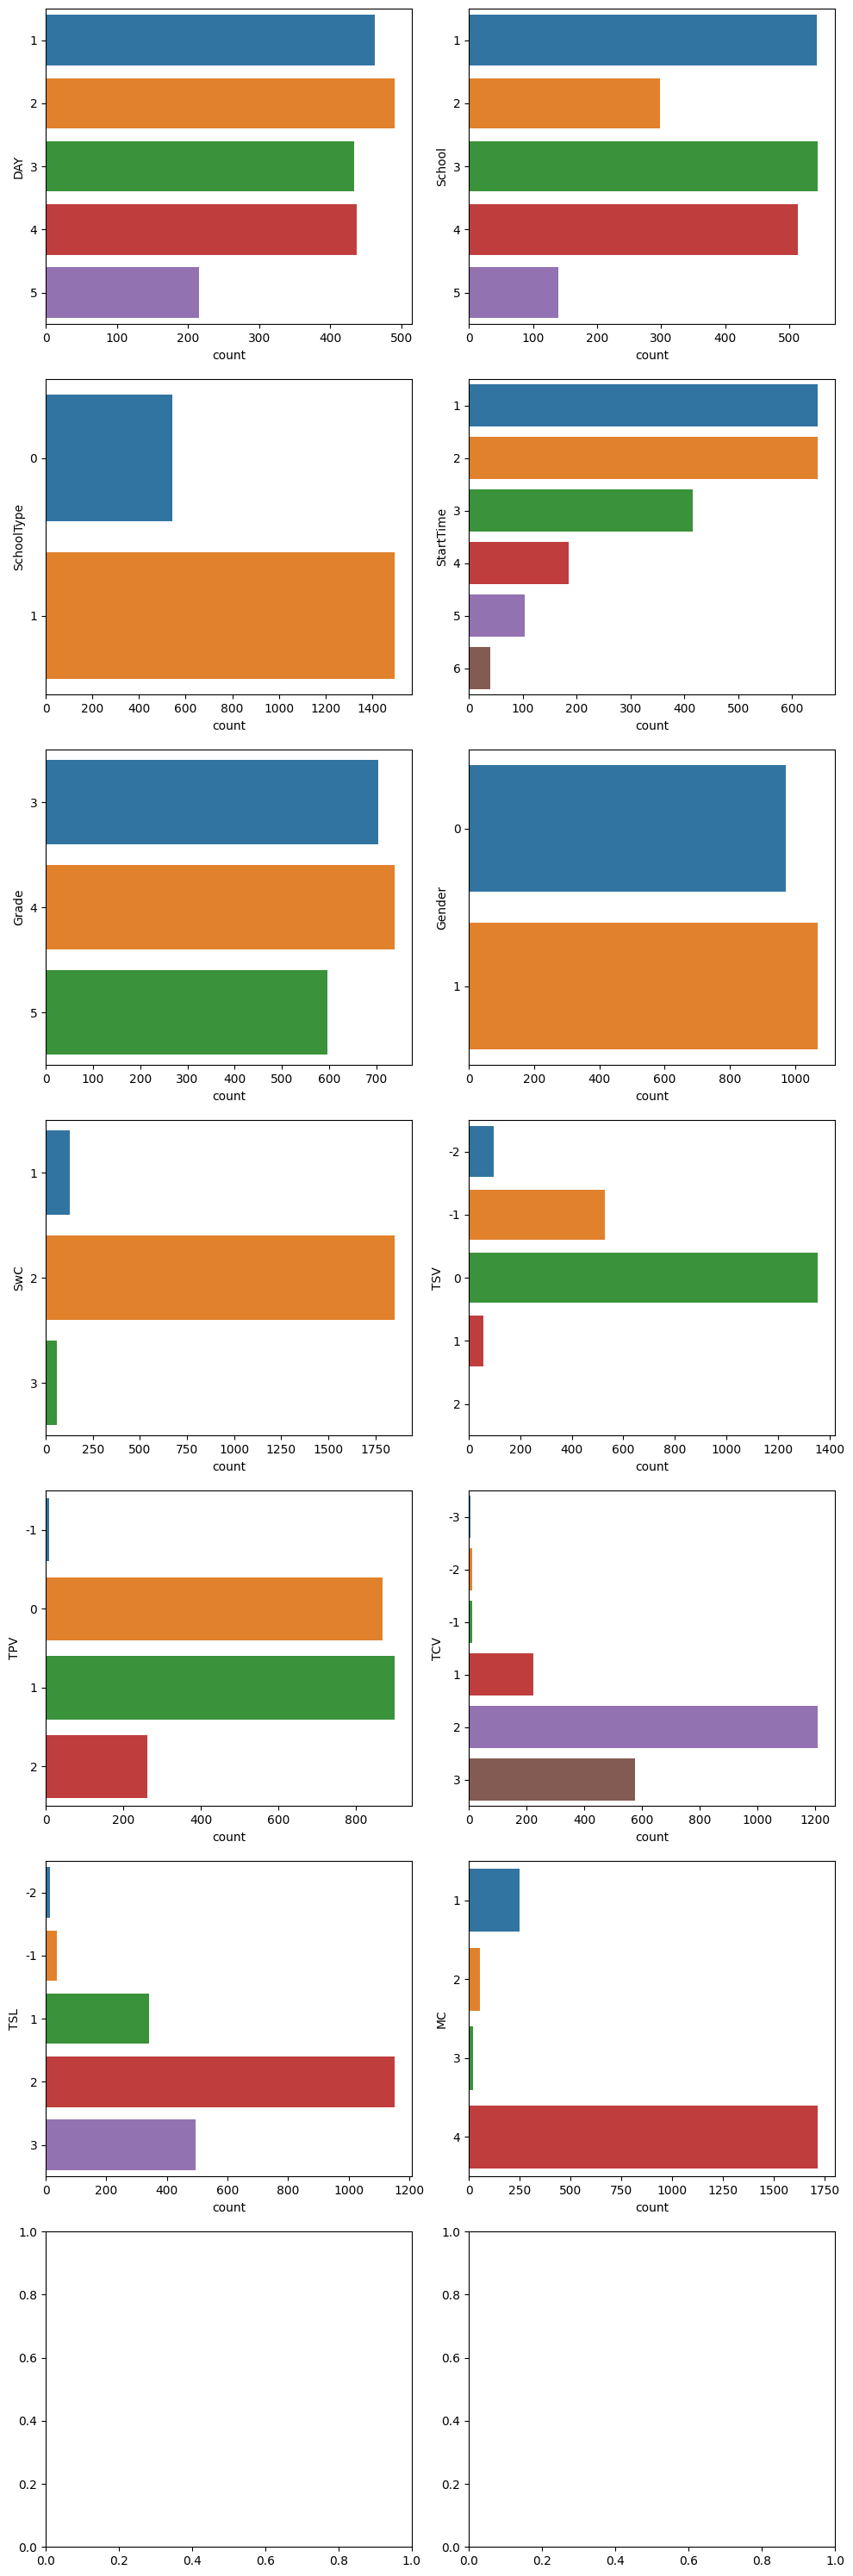

In [14]:
# create a new dataframe with columns containing only the categorical features
cat_features = winter_data.select_dtypes(include=['category']).copy()

# we plot individual column distributions with null entry rows dropped
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(10, 30))
plt.subplots_adjust(right=1.5, top=1.25)

for i in range(len(cat_features.columns)):
    plt.subplot(7, 2, i+1)
    sns.countplot(y=cat_features.columns[i], data=cat_features)
    
plt.tight_layout()
plt.show()

## Distributions of Boolean Features

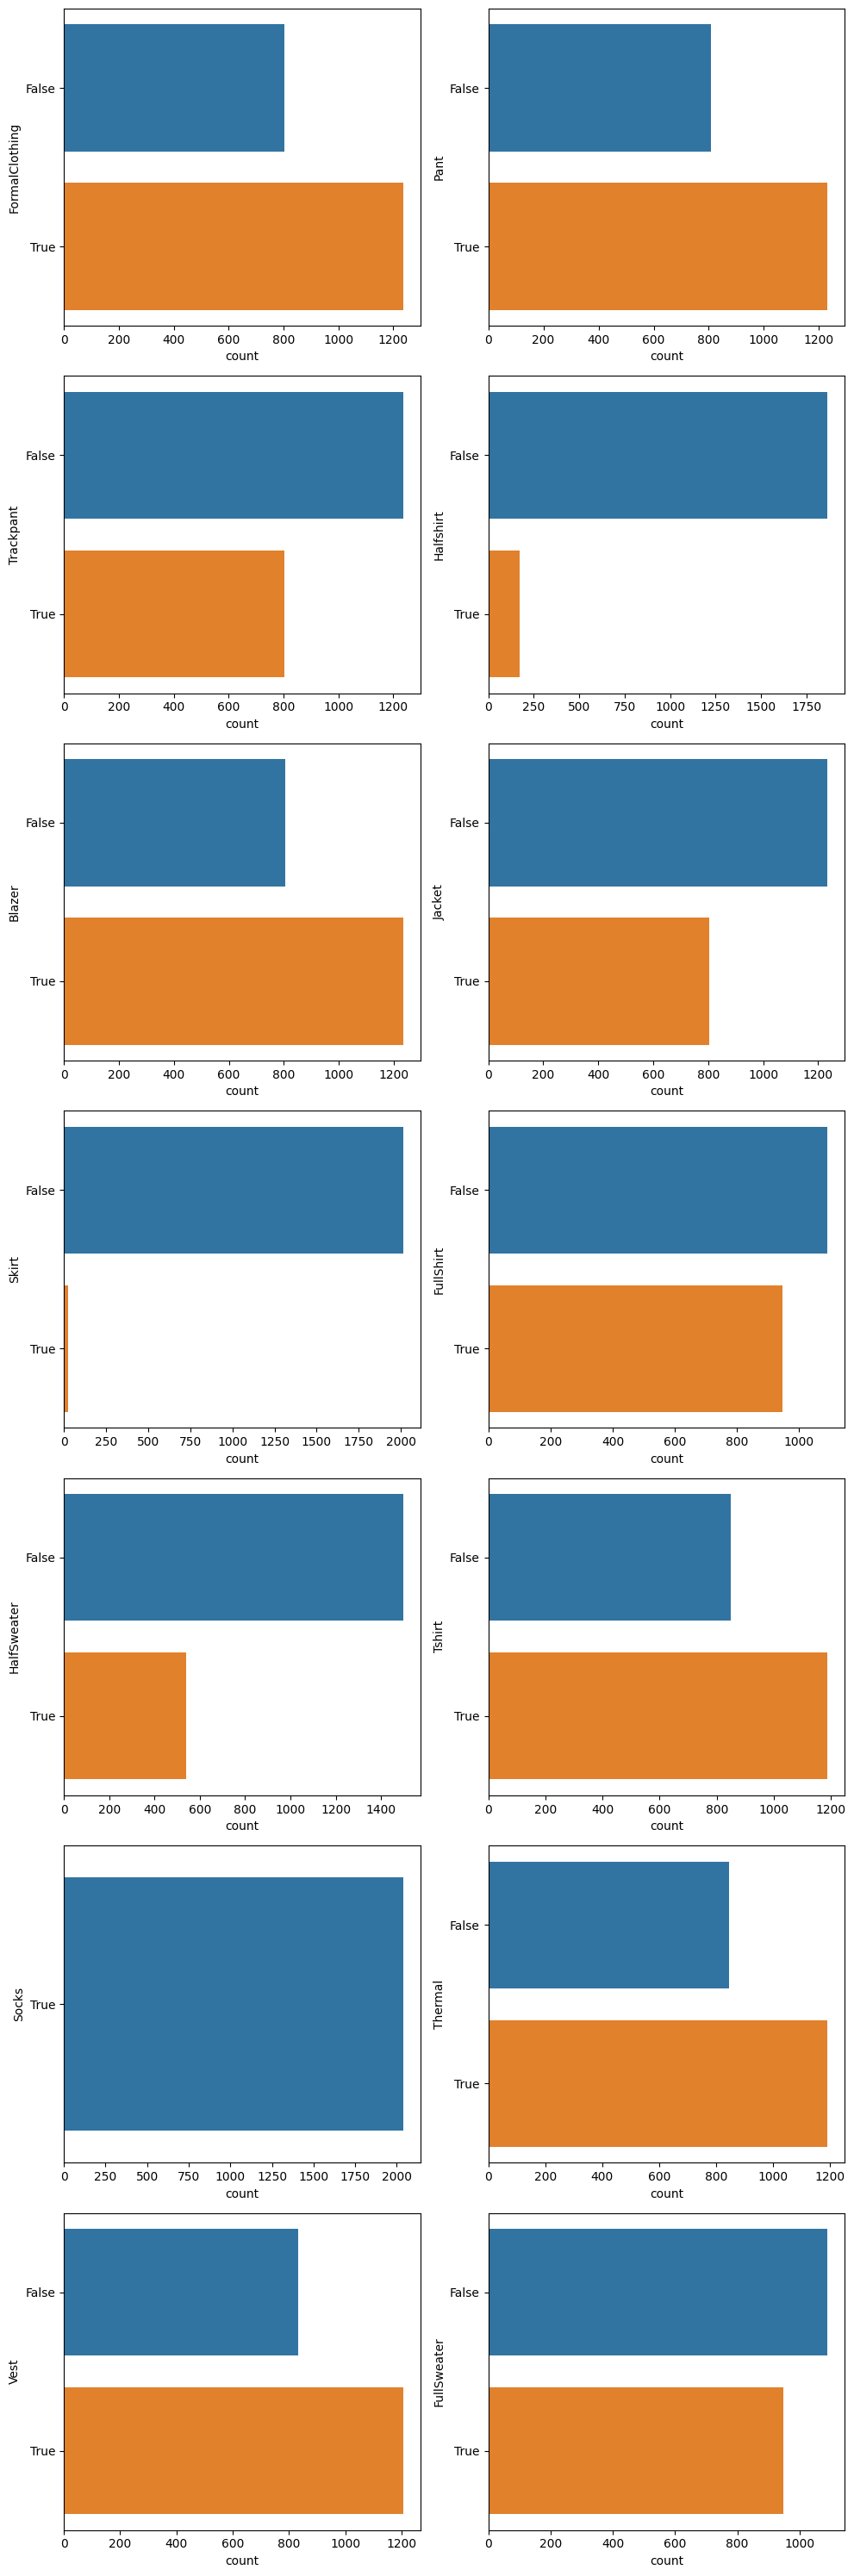

In [15]:
# create a new dataframe with columns containing only the categorical features
bool_features = winter_data.select_dtypes(include='bool').copy()

# we plot individual column distributions with null entry rows dropped
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(10, 30))
plt.subplots_adjust(right=1.5, top=1.25)

for i in range(len(bool_features.columns)):
    plt.subplot(7, 2, i+1)
    sns.countplot(y=bool_features.columns[i], data=bool_features)
    
plt.tight_layout()
plt.show()

In [16]:
tsl_target_data = winter_data.copy()

# Machine Learning Models (scikit-learn)

In [17]:
# Import classifiers
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import  make_pipeline

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV, GroupKFold, StratifiedKFold

# For standardization
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler

# For dimensionality reduction
from sklearn.decomposition import PCA



In [18]:
# Drop samples where target has samples < 2.
clean_winter_data = winter_data.copy()[winter_data.TPV != -1][winter_data.TSV != 2][winter_data.TCV != -3]
clean_winter_data.shape

(2023, 34)

In [19]:
sklearn_data = pd.get_dummies(clean_winter_data.copy().drop(['TSV', 'TPV',
       'TSL','TCV'], axis=1), cat_features.drop(['TSV', 'TPV',
       'TSL','TCV'], axis=1).columns)
sklearn_data.head()

,AvgMaxDailyTemp,AvgMinDailyTemp,AvgIndoorRelativeHumidity,IndoorTempDuringSurvey,Age,FormalClothing,Pant,Trackpant,Halfshirt,Blazer,...,Grade_5,Gender_0,Gender_1,SwC_1,SwC_2,SwC_3,MC_1,MC_2,MC_3,MC_4
SNo,,,,,,,,,,,,,,,,,,,,,
1,22.2,5.1,55.1,14.5,8,False,False,True,False,False,...,0,1,0,1,0,0,0,1,0,0
2,22.2,5.1,55.1,14.5,8,False,False,True,False,False,...,0,1,0,1,0,0,0,1,0,0
3,22.2,5.1,55.1,14.5,8,False,False,True,False,False,...,0,1,0,0,1,0,0,0,0,1
4,22.2,5.1,55.1,14.5,10,False,False,True,False,False,...,0,1,0,0,1,0,0,0,0,1
5,22.2,5.1,55.1,14.5,9,False,False,True,False,False,...,0,1,0,0,1,0,0,1,0,0


In [65]:
sklearn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 1 to 2038
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AvgMaxDailyTemp            2023 non-null   float64
 1   AvgMinDailyTemp            2023 non-null   float64
 2   AvgIndoorRelativeHumidity  2023 non-null   float64
 3   IndoorTempDuringSurvey     2023 non-null   float64
 4   Age                        2023 non-null   int64  
 5   FormalClothing             2023 non-null   bool   
 6   Pant                       2023 non-null   bool   
 7   Trackpant                  2023 non-null   bool   
 8   Halfshirt                  2023 non-null   bool   
 9   Blazer                     2023 non-null   bool   
 10  Jacket                     2023 non-null   bool   
 11  Skirt                      2023 non-null   bool   
 12  FullShirt                  2023 non-null   bool   
 13  HalfSweater                2023 non-null   bool 

## **1. Split the data**

In [20]:
# Define our features dataframe X and labels y
X= sklearn_data
y= clean_winter_data.TSV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=505, stratify=y)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))



1618 405
1618 405


In [21]:
# Pipeline dictionary
pipelines = {
    'lr': make_pipeline(StandardScaler(), 
                        LogisticRegressionCV(n_jobs=-1, random_state=505)),
   # 'rdg': make_pipeline(StandardScaler(),
    #                       RidgeClassifierCV()),
    'svc': make_pipeline(StandardScaler(),
                        SVC(random_state=505, probability=True)),
    'rf': make_pipeline(StandardScaler(), 
                            RandomForestClassifier(n_estimators=100, max_depth=15, random_state=505)),
    #Kneighbours
    'knc': make_pipeline(StandardScaler(),
                            KNeighborsClassifier(n_jobs=-1)),
    #gausian process
    'gpc': make_pipeline(StandardScaler(),
                            GaussianProcessClassifier(n_jobs=-1,random_state=505)),
}



## Choice of metric evaluation

1. Quadratic Cohen's Kappa

    Cohen’s kappa statistic measures interrater reliability (sometimes called interobserver agreement). Interrater reliability, or precision, happens when your data raters (or collectors) give the same score to the same data item. In our case, we have labels VS predictions. The Kappa statistic takes into account this element of chance.

The Kappa statistic varies from 0 to 1, where.

0 = agreement equivalent to chance.\ 0.1 – 0.20 = slight agreement.\ 0.21 – 0.40 = fair agreement.\ 0.41 – 0.60 = moderate agreement.\ 0.61 – 0.80 = substantial agreement.\ 0.81 – 0.99 = near perfect agreement\ 1 = perfect agreement.

2. Micro-averaged Precision score

    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

For multiclass classification, Micro-average is preferable if there is a class imbalance problem.

In [22]:
# Classification metrics 
from sklearn.metrics import precision_score, accuracy_score, cohen_kappa_score

# Initiate empty dictionary of fitted base models
fitted_basemodels = {}
# Loop through model pipelines
for name, pipeline in pipelines.items():
  
    # Fit model on X_train, y_train  and predict with X_test
    base_mod = pipeline.fit(X_train, y_train)
    #pred = pipeline.predict(X_test)
    pred = pipeline.predict(X_test)
    pred_prob = pipeline.predict_proba(X_test)
    
    # Store model in fitted_models[name] 
    fitted_basemodels[name] = base_mod
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')
   # print('accuracy on test: ', pipeline.score(X_test,y_test))
    print('precision scores: ', precision_score(y_test, pred,  average='micro'))
    print('Accuracy scores ', accuracy_score(y_test, pred))
    print('Kappa on test: ', cohen_kappa_score(y_test, pred, weights='quadratic'))
    print('\n')  

lr has been fitted.
precision scores:  0.671604938271605
Accuracy scores  0.671604938271605
Kappa on test:  0.05161726586272952


svc has been fitted.
precision scores:  0.6938271604938272
Accuracy scores  0.6938271604938272
Kappa on test:  0.08204665840189329


rf has been fitted.
precision scores:  0.6839506172839506
Accuracy scores  0.6839506172839506
Kappa on test:  0.16967061686117246


knc has been fitted.
precision scores:  0.6370370370370371
Accuracy scores  0.6370370370370371
Kappa on test:  0.17771206647022686


gpc has been fitted.
precision scores:  0.6271604938271605
Accuracy scores  0.6271604938271605
Kappa on test:  0.1212507977026166




**3. Hyperparameter tuning (Optional)**

In [23]:
pipelines['rf'].get_params() # This is how we get the format of hyperparameter dictionaries for GridSearch

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier',
   RandomForestClassifier(max_depth=15, random_state=505))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(max_depth=15, random_state=505),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n

In [24]:
# Create a dictionary for each models hyperparameters

svc_hyparams = {'svc__C': [0.1, 1, 10, 100, 1000],
               'svc__gamma': [0.1, 1, 10, 100]
               }

rf_hyparams  = {
    'randomforestclassifier__n_estimators': [100,200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__max_depth': [8, 15],
    'randomforestclassifier__min_samples_split': [2, 5 ],
    'randomforestclassifier__min_samples_leaf': [1, 2, 10]
}

knc_hyparams =  {
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 1.5 , 2, 10],
    'kneighborsclassifier__n_neighbors': np.arange(2,10),
 }



In [25]:
# Now create a dictionary of hyperparameter dictionaries !?
hyperparameters = {
    'lr': {},
    'svc': svc_hyparams,
    'rf': rf_hyparams,
    'knc': knc_hyparams,
    'gpc':{}
}



In [26]:


# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')



lr has been fitted.
svc has been fitted.
rf has been fitted.
knc has been fitted.
gpc has been fitted.


In [29]:
import pickle
for name, model in fitted_models.items():
    pickle.dump(model, open(name+'.sav', 'wb'))

In [45]:
fitted_models['lr']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregressioncv',
                                        LogisticRegressionCV(n_jobs=-1,
                                                             random_state=505))]),
             n_jobs=-1, param_grid={})

In [30]:


for name, model in fitted_models.items():
    
    pred = model.predict(X_test)
    print('precision score: ', precision_score(y_test, pred,  average='micro'))
    print('Accuracy scores ', accuracy_score(y_test, pred))
    print(name,'Kappa on test:', cohen_kappa_score(y_test, pred, weights='quadratic'))
    print('-'*30)



precision score:  0.671604938271605
Accuracy scores  0.671604938271605
lr Kappa on test: 0.05161726586272952
------------------------------
precision score:  0.6691358024691358
Accuracy scores  0.6691358024691358
svc Kappa on test: 0.0
------------------------------
precision score:  0.691358024691358
Accuracy scores  0.691358024691358
rf Kappa on test: 0.0894673520726239
------------------------------
precision score:  0.6469135802469136
Accuracy scores  0.6469135802469136
knc Kappa on test: 0.05489088984256707
------------------------------
precision score:  0.6271604938271605
Accuracy scores  0.6271604938271605
gpc Kappa on test: 0.1212507977026166
------------------------------


['Underwear' 'Shoes' 'Socks' 'StartTime_6' 'StartTime_5' 'School_5'
 'SchoolType_0' 'SchoolType_1' 'Pant' 'Trackpant' 'Blazer' 'School_1'
 'Jacket' 'FormalClothing' 'MC_3' 'DAY_5' 'School_3' 'StartTime_4'
 'School_2' 'Skirt' 'StartTime_3' 'DAY_1' 'DAY_3' 'DAY_2' 'MC_2'
 'StartTime_1' 'StartTime_2' 'DAY_4' 'SwC_3' 'Grade_3' 'School_4'
 'Grade_5' 'SwC_1' 'Grade_4' 'Halfshirt' 'FullShirt' 'MC_1'
 'AvgMinDailyTemp' 'TA' 'MC_4' 'SwC_2' 'AvgMaxDailyTemp' 'Tshirt'
 'Gender_1' 'Gender_0' 'IndoorTempDuringSurvey' 'HalfSweater'
 'AvgIndoorRelativeHumidity' 'FullSweater' 'Vest' 'Thermal' 'Age']
[0.         0.         0.         0.00183006 0.00226036 0.00271591
 0.00279583 0.00310654 0.00318244 0.00345304 0.00348923 0.00349248
 0.00371084 0.0045235  0.00460433 0.00488273 0.00500244 0.00541822
 0.00602394 0.00640215 0.00644752 0.00704137 0.00716086 0.00840136
 0.00863589 0.00878253 0.0089587  0.00956327 0.01063478 0.01223608
 0.01427627 0.01571803 0.01596078 0.01624111 0.01820544 0.02081398
 0.0208

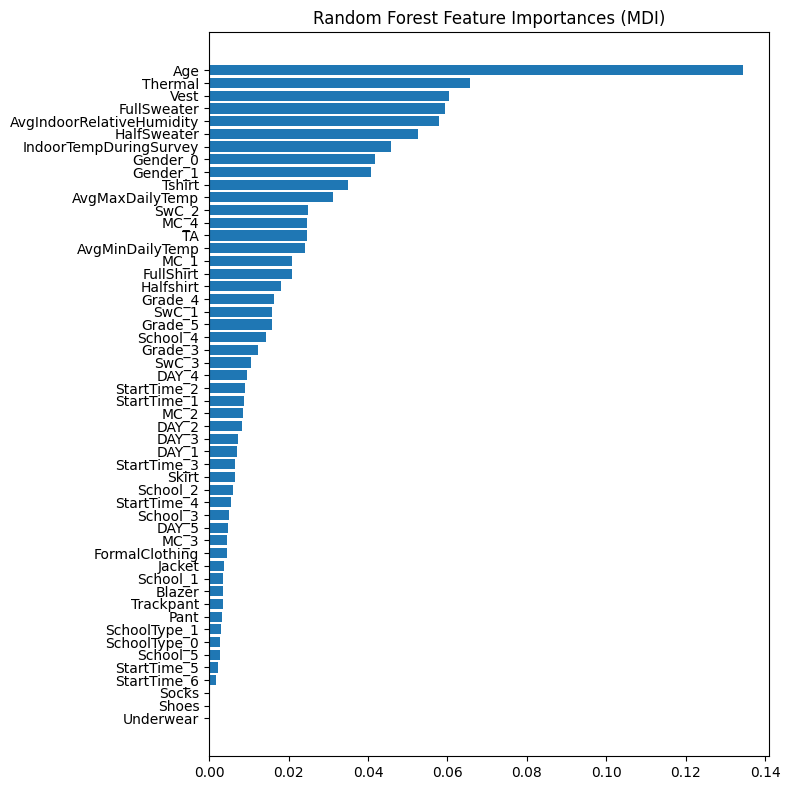

In [31]:


feature_names = np.r_[X_train.columns.to_list()]
tree_feature_importances = (
    fitted_models['rf'].estimator['randomforestclassifier'].feature_importances_.reshape(1,len(feature_names))[0])
sorted_idx = tree_feature_importances.argsort()
print(feature_names[sorted_idx])
print(tree_feature_importances[sorted_idx])

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()



In [32]:
import dice_ml

In [64]:
d = dice_ml.Data(dataframe=X_train, continuous_features=['AvgMaxDailyTemp', 'AvgMinDailyTemp',
                                                        'AvgIndoorRelativeHumidity', 'IndoorTempDuringSurvey'],
                                                        outcome_name='Age')

In [47]:
m = dice_ml.Model(model=fitted_models['lr'], backend='sklearn')

In [49]:
exp = dice_ml.Dice(d,m)

In [66]:
query_instance = X_test[0:1].drop('Age', axis=1)

In [67]:
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Age


## Machine Learning Models (CatBoost)

In [ ]:
import catboost as cat
# Classification metrics 
from sklearn.metrics import precision_score, cohen_kappa_score, f1_score, accuracy_score, recall_score
# Helper for cross-validation
from sklearn.model_selection import StratifiedKFold

In [ ]:
def oof_trainer(X: pd.DataFrame,
                y,
            n_folds = None,
            params: dict = None,
            del_cols: list = None,
            cat_features=None):
    
    """This function trains multiple Catboost model while performing stratified CV with shuffling.
    out-of-fold (oof) predictions are evaluated at each fold and printed out 
    at the end of the routine as a list. The mean scores on all fold is also printed out.
    
    The metrics used for evaluation are precision_auc and the cohen's kappa
    
    Output: 
    models -- a list of models trained on each fold during CV
    oof_pred -- prediction array consisting of predictions coming from different models
    """
        
    # collect models and scores from each fold
    models = []
    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    scores = []
    # CV splitter
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=505) #GroupKFold(n_splits=n_folds) 
    #features to use
    columns = [col for col in X.columns.values if not col in del_cols]
    # dimension of the target 
    n_target=1
    
    # collect out-of-sample predictions
    data_X, data_y, oof_pred = pd.DataFrame(), pd.Series(), np.zeros((len(X),n_target))


    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
     
        print('Fold {} started at {}'.format(fold_n + 1,time.ctime()))
        #print((train_index, valid_index))
        X_train, X_valid = X.iloc[train_index][columns], X.iloc[valid_index][columns]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        data_X = data_X.append(X_valid)
        data_y = data_y.append(y_valid)
        print(data_X.shape)
        
        #Eval set preparation
        eval_set = [(X_train, y_train)]
       # eval_names = ['train']
        eval_set.append((X_valid, y_valid))
       # eval_names.append('valid')
    
        model = cat.CatBoostClassifier()
        model.fit(X=X_train, y=y_train, 
                       eval_set=eval_set, 
                       verbose=500, early_stopping_rounds=150,
                      cat_features=cat_features, use_best_model=True, plot=True)
        
        oof_pred[valid_index] = model.predict(X_valid).reshape(-1, n_target)
        models.append(model)
    
        print('-'*30)
        
        scores.append(cohen_kappa_score(y_valid, oof_pred[valid_index], weights='quadratic'))
        f1_scores.append(f1_score(y_valid, oof_pred[valid_index],   average=None))
        accuracy_scores.append(accuracy_score(y_valid, oof_pred[valid_index]))
        precision_scores.append(precision_score(y_valid, oof_pred[valid_index],   average=None))
        recall_scores.append(recall_score(y_valid, oof_pred[valid_index],   average=None))

    print(f'catb fold kappa scores: {scores}')
    print(f'catb fold kappa scores mean: {np.mean(scores)}')
    print(f'catb fold f1 scores: {f1_scores}')
    print(f'catb fold f1 scores mean: {np.mean(f1_scores)}')
    print(f'catb fold precision-micro scores: {precision_scores}')
    print(f'catb fold precision-micro scores mean: {np.mean(precision_scores)}')
    print(f'catb fold recall-micro scores: {recall_scores}')
    print(f'catb fold recall-micro scores mean: {np.mean(recall_scores)}')
    print(f'catb fold accuracy scores: {accuracy_scores}')
    print(f'catb fold accuracy scores mean: {np.mean(accuracy_scores)}')
   
    return models, oof_pred


# Target: TSL

In [ ]:
# feature selection for Catboost
models, oof_pred = oof_trainer(X=tsl_target_data,
                    y=tsl_target_data.TSL,
                    n_folds = 5,
                   # params=params,
                    del_cols=['TSV',
       'TPV','TCV', 'TSL'],
                    cat_features=cat_features.drop(columns=['TSV',
       'TPV','TCV', 'TSL']).columns.values.tolist())

Fold 1 started at Tue Sep 13 00:12:13 2022
(408, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.5052314	test: 1.5052314	test1: 1.5055811	best: 1.5055811 (0)	total: 175ms	remaining: 2m 54s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9855059234
bestIteration = 131

Shrink model to first 132 iterations.
------------------------------
Fold 2 started at Tue Sep 13 00:12:26 2022
(816, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.5054537	test: 1.5054537	test1: 1.5063457	best: 1.5063457 (0)	total: 34.5ms	remaining: 34.5s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9606132682
bestIteration = 155

Shrink model to first 156 iterations.
------------------------------
Fold 3 started at Tue Sep 13 00:12:39 2022
(1224, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.5062203	test: 1.5062203	test1: 1.5123039	best: 1.5123039 (0)	total: 35.8ms	remaining: 35.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9889006918
bestIteration = 128

Shrink model to first 129 iterations.
------------------------------
Fold 4 started at Tue Sep 13 00:12:52 2022
(1631, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109038
0:	learn: 1.5101131	test: 1.5101131	test1: 1.5168090	best: 1.5168090 (0)	total: 35.6ms	remaining: 35.6s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9800428481
bestIteration = 214

Shrink model to first 215 iterations.
------------------------------
Fold 5 started at Tue Sep 13 00:13:07 2022
(2038, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109038
0:	learn: 1.5131175	test: 1.5128736	test1: 1.5156214	best: 1.5156214 (0)	total: 33.7ms	remaining: 33.7s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9910530584
bestIteration = 154

Shrink model to first 155 iterations.
------------------------------
catb fold kappa scores: [0.19721026280415344, 0.1507936507936508, 0.17868305345128999, 0.21942289251155078, 0.15133391111835737]
catb fold kappa scores mean: 0.17948875413580048
catb fold f1 scores: [array([0.        , 0.        , 0.1025641 , 0.73234811, 0.21848739]), array([0.        , 0.        , 0.25882353, 0.71523179, 0.11965812]), array([0.        , 0.        , 0.21276596, 0.70588235, 0.19402985]), array([0.        , 0.25      , 0.19354839, 0.71034483, 0.24615385]), array([0.        , 0.        , 0.30434783, 0.6958042 , 0.18571429])]
catb fold f1 scores mean: 0.23382818303625663
catb fold precision-micro scores: [array([0.        , 0.        , 0.44444444, 0.5883905 , 0.65      ]), a

## Feature importance

In [ ]:
best_gb_model = models[1]
best_gb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,School,8.995579
1,AvgIndoorRelativeHumidity,8.176524
2,DAY,7.908865
3,Grade,7.490787
4,Age,6.920642
5,IndoorTempDuringSurvey,6.600062
6,TA,5.851666
7,Vest,5.679902
8,StartTime,5.571977
9,AvgMinDailyTemp,4.989981


# Target: TPV

In [ ]:
# feature selection for Catboost
# Remove all rows with TPV value -1
models, oof_pred = oof_trainer(X=tsl_target_data[tsl_target_data.TPV != -1],
                    y=tsl_target_data[tsl_target_data.TPV != -1].TPV,
                    n_folds = 5,
                   # params=params,
                    del_cols=['TSV',
       'TSL','TCV', 'TSL', 'TPV'],
                    cat_features=cat_features.drop(columns=['TSV', 'TPV',
       'TSL','TCV', 'TSL']).columns.values.tolist())

Fold 1 started at Tue Sep 13 00:13:21 2022
(406, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109027
0:	learn: 1.0717463	test: 1.0717463	test1: 1.0761554	best: 1.0761554 (0)	total: 46.8ms	remaining: 46.7s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9194651707
bestIteration = 175

Shrink model to first 176 iterations.
------------------------------
Fold 2 started at Tue Sep 13 00:13:36 2022
(812, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109027
0:	learn: 1.0732017	test: 1.0731809	test1: 1.0755733	best: 1.0755733 (0)	total: 45ms	remaining: 45s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9210748243
bestIteration = 99

Shrink model to first 100 iterations.
------------------------------
Fold 3 started at Tue Sep 13 00:13:46 2022
(1218, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109027
0:	learn: 1.0744489	test: 1.0743419	test1: 1.0770045	best: 1.0770045 (0)	total: 31ms	remaining: 31s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9148383262
bestIteration = 145

Shrink model to first 146 iterations.
------------------------------
Fold 4 started at Tue Sep 13 00:13:55 2022
(1624, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109027
0:	learn: 1.0725793	test: 1.0726985	test1: 1.0734870	best: 1.0734870 (0)	total: 28.9ms	remaining: 28.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9100770866
bestIteration = 159

Shrink model to first 160 iterations.
------------------------------
Fold 5 started at Tue Sep 13 00:14:10 2022
(2029, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109028
0:	learn: 1.0750545	test: 1.0750545	test1: 1.0764391	best: 1.0764391 (0)	total: 54.1ms	remaining: 54s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8927345289
bestIteration = 130

Shrink model to first 131 iterations.
------------------------------
catb fold kappa scores: [0.18298390116061403, 0.27285808318153304, 0.2960990712074303, 0.1490508413677466, 0.3287362792006755]
catb fold kappa scores mean: 0.24594563522359988
catb fold f1 scores: [array([0.52631579, 0.56930693, 0.18181818]), array([0.5974026 , 0.51630435, 0.13559322]), array([0.57617729, 0.54639175, 0.25396825]), array([0.54545455, 0.57731959, 0.13888889]), array([0.5915493 , 0.57142857, 0.28571429])]
catb fold f1 scores mean: 0.4409089022871028
catb fold precision-micro scores: [array([0.53254438, 0.51339286, 0.46153846]), array([0.5450237 , 0.5026455 , 0.66666667]), array([0.55614973, 0.50961538, 0.72727273]), array([0.53932584, 0.53846154, 0.25      ]), array([0.576923

In [ ]:
best_gb_model = models[4]
best_gb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Grade,12.337336
1,School,12.137193
2,StartTime,9.750423
3,SwC,5.584209
4,AvgIndoorRelativeHumidity,5.551543
5,AvgMaxDailyTemp,5.513091
6,IndoorTempDuringSurvey,5.329774
7,DAY,5.143675
8,Thermal,4.909199
9,MC,4.798455


# Target: TSV

In [ ]:
models, oof_pred = oof_trainer(X=tsl_target_data[tsl_target_data.TSV != 2],
                    y=tsl_target_data[tsl_target_data.TSV != 2].TSV,
                    n_folds = 5,
                   # params=params,
                    del_cols=['TSV',
       'TSL','TCV', 'TSL', 'TPV'],
                    cat_features=cat_features.drop(columns=['TSV', 'TPV',
       'TSL','TCV', 'TSL']).columns.values.tolist())

Fold 1 started at Tue Sep 13 00:14:23 2022
(408, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109035
0:	learn: 1.2814452	test: 1.2814452	test1: 1.2851394	best: 1.2851394 (0)	total: 54ms	remaining: 54s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7503238686
bestIteration = 193

Shrink model to first 194 iterations.
------------------------------
Fold 2 started at Tue Sep 13 00:14:43 2022
(816, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109035
0:	learn: 1.2752055	test: 1.2709292	test1: 1.2762458	best: 1.2762458 (0)	total: 55ms	remaining: 55s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8331112153
bestIteration = 130

Shrink model to first 131 iterations.
------------------------------
Fold 3 started at Tue Sep 13 00:14:54 2022
(1223, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.2805226	test: 1.2797919	test1: 1.2830096	best: 1.2830096 (0)	total: 29.5ms	remaining: 29.4s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7954396619
bestIteration = 137

Shrink model to first 138 iterations.
------------------------------
Fold 4 started at Tue Sep 13 00:15:04 2022
(1630, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.2887858	test: 1.2887858	test1: 1.2881374	best: 1.2881374 (0)	total: 26.7ms	remaining: 26.7s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7832695063
bestIteration = 267

Shrink model to first 268 iterations.
------------------------------
Fold 5 started at Tue Sep 13 00:15:18 2022
(2037, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109036
0:	learn: 1.2816245	test: 1.2816245	test1: 1.2817547	best: 1.2817547 (0)	total: 27.7ms	remaining: 27.6s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7870446772
bestIteration = 92

Shrink model to first 93 iterations.
------------------------------
catb fold kappa scores: [0.12043819705668835, 0.10618196754980491, 0.09756097560975607, 0.07411889953493578, 0.0829780017443551]
catb fold kappa scores mean: 0.09625560829910804
catb fold f1 scores: [array([0.09090909, 0.29577465, 0.79874214, 0.25      ]), array([0.        , 0.19548872, 0.80864198, 0.15384615]), array([0.        , 0.171875  , 0.81105991, 0.125     ]), array([0.08695652, 0.17266187, 0.79310345, 0.        ]), array([0.        , 0.144     , 0.80851064, 0.        ])]
catb fold f1 scores mean: 0.2853285057385533
catb fold precision-micro scores: [array([0.5       , 0.58333333, 0.69589041, 0.4       ]), array([0.        , 0.48148148, 0.69496021, 0.5       ]), array([0.        , 

In [ ]:
best_gb_model = models[0]
best_gb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,School,11.863544
1,Grade,8.366431
2,StartTime,7.881729
3,IndoorTempDuringSurvey,6.573328
4,SwC,6.073033
5,AvgIndoorRelativeHumidity,5.738325
6,Age,5.357605
7,AvgMaxDailyTemp,4.901973
8,DAY,4.870989
9,Thermal,4.726143


# Target: TCV

In [ ]:
models, oof_pred = oof_trainer(X=tsl_target_data[tsl_target_data.TCV != -3],
                    y=tsl_target_data[tsl_target_data.TCV != -3].TCV,
                    n_folds = 5,
                   # params=params,
                    del_cols=['TSV',
       'TSL','TCV', 'TSL', 'TPV'],
                    cat_features=cat_features.drop(columns=['TSV', 'TPV',
       'TSL','TCV', 'TSL']).columns.values.tolist())

Fold 1 started at Tue Sep 13 00:15:26 2022
(407, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109031
0:	learn: 1.4921845	test: 1.4921845	test1: 1.4929105	best: 1.4929105 (0)	total: 50.8ms	remaining: 50.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8458613347
bestIteration = 172

Shrink model to first 173 iterations.
------------------------------
Fold 2 started at Tue Sep 13 00:15:39 2022
(814, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109031
0:	learn: 1.4941543	test: 1.4941543	test1: 1.5003288	best: 1.5003288 (0)	total: 31ms	remaining: 31s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9091748395
bestIteration = 132

Shrink model to first 133 iterations.
------------------------------
Fold 3 started at Tue Sep 13 00:15:50 2022
(1221, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109031
0:	learn: 1.4903985	test: 1.4903985	test1: 1.4948514	best: 1.4948514 (0)	total: 32ms	remaining: 32s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8978507848
bestIteration = 124

Shrink model to first 125 iterations.
------------------------------
Fold 4 started at Tue Sep 13 00:16:01 2022
(1627, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109032
0:	learn: 1.4840030	test: 1.4840030	test1: 1.4852604	best: 1.4852604 (0)	total: 33.6ms	remaining: 33.6s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8632433696
bestIteration = 215

Shrink model to first 216 iterations.
------------------------------
Fold 5 started at Tue Sep 13 00:16:15 2022
(2033, 30)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109032
0:	learn: 1.4868318	test: 1.4868072	test1: 1.4870231	best: 1.4870231 (0)	total: 40.7ms	remaining: 40.7s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8610749989
bestIteration = 144

Shrink model to first 145 iterations.
------------------------------
catb fold kappa scores: [0.232251754114559, 0.15062075427500587, 0.1573853186905576, 0.25297110338032136, 0.15562185587665234]
catb fold kappa scores mean: 0.18977015726741925
catb fold f1 scores: [array([0.        , 0.        , 0.14035088, 0.74827586, 0.34883721]), array([0.        , 0.        , 0.        , 0.74172185, 0.27272727]), array([0.        , 0.        , 0.16      , 0.74791319, 0.275     ]), array([0.        , 0.        , 0.18867925, 0.74255692, 0.38043478]), array([0.        , 0.        , 0.14814815, 0.75496689, 0.26845638])]
catb fold f1 scores mean: 0.23672274484912809
catb fold precision-micro scores: [array([0.        , 0.        , 0.33333333, 0.64201183, 0.52631579]), arr

In [ ]:
best_gb_model = models[0]
best_gb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,School,10.830895
1,Grade,9.139877
2,AvgIndoorRelativeHumidity,8.147633
3,IndoorTempDuringSurvey,7.220925
4,StartTime,7.216548
5,DAY,6.907853
6,MC,5.977789
7,Age,5.013823
8,Gender,4.607006
9,TA,4.264142
